In [14]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest,norm
import matplotlib.pyplot as plt
import json
from datetime import timedelta
import pandas as pd
from scipy.stats.stats import pearsonr
import bisect
import scipy.stats as ss
import bisect

# Load Data

In [2]:
def parse_file_json(file_name):
    with open(file_name, "r") as f:
        data = [json.loads(line) for line in f]
    starting_time = parser.parse(data[0][0])
    starting_bids = data[0][1]
    starting_asks = data[0][2]
    
    raw_updates = data[1:]
    
    Bids = {}
    Asks = {}    
    
    updates = []
    
    for price, amount in starting_bids:
        Bids[int(round((float(price)*100)))] = float(amount)
    for price, amount in starting_asks:
        Asks[int(round((float(price)*100)))] = float(amount)
        
    for u in raw_updates:
        price = int(round((float(u["price"])*100)))  
        side = u["side"]
        amount = float(u["amount"])
        time = parser.parse(u["time"])
        
        if side == "buy":
            change = amount - Bids.get(price,0)
        else:
            change = amount - Asks.get(price,0)
        
        updates.append({\
            "Bids": copy.copy(Bids), \
            "Asks": copy.copy(Asks), \
            "time": time, \
            "side": side, \
            "price": price, \
            "change": change            
        })
        
        if side == "buy":
            if u["amount"] == "0":
                del Bids[price]
            else:
                Bids[price] = float(amount)
        else:
            if u["amount"] == "0":
                del Asks[price]
            else:
                Asks[price] = float(amount)   

    return(starting_time, updates)

In [3]:
def shortened_updates(file_name,K):
    starting_time, updates = parse_file_json(file_name)
    
    res = []
    
    # Caluclate first reference price
    starting_bids = updates[0]['Bids']
    starting_asks = updates[0]['Asks']
    sorted_bids = list(reversed(sorted(starting_bids.items())))
    sorted_asks = list(sorted(starting_asks.items()))        
    best_bid = sorted_bids[0][0]
    best_ask = sorted_asks[0][0]
    if ((best_bid + best_ask) % 2) != 0:
        old_reference_price = round((best_bid+best_ask)/2, 1)
    else:
        old_reference_price = round((best_bid+best_ask+1)/2, 1)
            
    for u in updates:      
        # Find reference price
        sorted_bids = list(reversed(sorted(u['Bids'].items())))
        sorted_asks = list(sorted(u['Asks'].items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if old_reference_price > middle:
                reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                old_reference_price = round((best_bid+best_ask)/2 - 0.5,1)
                
        shortened_book = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
        first_bid = int(round(reference_price - 0.5))
        first_ask = int(round(reference_price + 0.5))        
        for k in range(-K,0):
            shortened_book[k] = u['Bids'].get(first_bid + k + 1,0)
        for k in range(1,K+1):
            shortened_book[k] = u['Asks'].get(first_ask + k - 1,0)
            
        # Find k from the price. Keep track of event if
        # abs(k) <= K
        price = u["price"]
        k = price - reference_price
        if k < 0:
            k = int(round(k - 0.5))
        else:
            k = int(round(k + 0.5))
        if abs(k) <= K:                 
            res.append({
                'reference_price': reference_price,
                'LOB': copy.copy(shortened_book),
                'k': k,
                'change': u['change'],
                'time': u['time']
            })
        
        old_reference_price = reference_price

    return starting_time, res

# Combine Updates that Occur At Same Time

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [4]:
def processed_updates(file_name,K):
    starting_time,updates = shortened_updates(file_name,10)
    grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
    # Contains dictionary of time, reference price, order book, list of changes
    cleaned_updates = []
    for t, us in grouped_by_time.items():
        if len(us) == 1:
            u = us[0]
            cleaned_updates.append(copy.copy(u))
        else:
            new_update = {'time': t}
            us = sorted(us, key=lambda u:-abs(u['k']))
            grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
            reference_k = list(grouped_by_k.keys())[0]
            new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
            new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
            events = []
            for k in grouped_by_k:
                combined_change = 0
                for u in grouped_by_k[k]:
                    combined_change = combined_change + u['change']
                events.append((k,combined_change))
            for k,change in events:
                new_update = copy.deepcopy(new_update)
                new_update['k'] = k
                new_update['change'] = change
                cleaned_updates.append(new_update)
    
    combined_updates = []
    i = 0
    while i < len(cleaned_updates):
        reference_price = cleaned_updates[i]['reference_price']
        j = i
        updates_at_reference = []
        while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
            updates_at_reference.append(cleaned_updates[j])
            j += 1
        updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
        for k,us in grouped_by_k.items():
            us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
            keep_index = [True for u in us]
            for m in reversed(range(1,len(us))):
                quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
                same_sign = (us[m]['change'] * us[m-1]['change']) > 0
                if quick_same_order and same_sign:
                    us[m-1]['change'] += us[m]['change']
                    keep_index[m] = False
            for (u,keep) in zip(us, keep_index):
                if keep:
                    combined_updates.append(u)
        i = j + 1

    combined_updates = sorted(combined_updates,key=lambda u:u['time'])
    
    ending_time = combined_updates[-1]['time']
    
    return starting_time, ending_time, combined_updates

starting_time, ending_time, combined_updates = processed_updates('12_28_18.json',10)
len(combined_updates)

305806

In [5]:
starting_times, ending_times, time_period_updates = zip(*[processed_updates(f,10) for f in ['12_28_18.json','12_29_18.json','12_30_18.json']])

In [64]:
with open('processed_data.pkl', 'wb') as f:
    pickle.dump([starting_times, ending_times, time_period_updates], f)

# START HERE

In [15]:
with open('processed_data.pkl', 'rb') as f:
    starting_times, ending_times, all_updates = pickle.load(f)

In [16]:
all_update_times = []
for updates in all_updates:
    all_update_times.append([u['time'] for u in updates])

# Sample intervals

In [17]:
def updates_during_period(updates, update_times, start, end):
    left_index = bisect.bisect_left(update_times, start)
    right_index = bisect.bisect_right(update_times, end)
    return updates[left_index: right_index + 1]

    
def updates_during_random_period(updates, update_times, starting_time, ending_time, size):
    total_length = (ending_time - starting_time).total_seconds()
    interval_start = starting_time + timedelta(seconds=np.random.uniform()*(total_length - size))
    return updates_during_period(updates, update_times, interval_start, interval_start + timedelta(seconds=size))

def updates_during_random_period_multiple_dates(size):
    probabilities = [(e-s).total_seconds() - size for (s,e) in zip(starting_times, ending_times)]
    probabilities = [p/sum(probabilities) for p in probabilities]
    I = np.random.choice(len(all_updates), p=probabilities)
    return updates_during_random_period(all_updates[I], all_update_times[I], starting_times[I], ending_times[I], size)

In [18]:
K = 10
positive_updates = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
negative_updates = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])

for _ in range(160000):
    updates = updates_during_random_period_multiple_dates(60)
    num_positive = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    num_negative = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    
    for u in updates:
        if u['change'] > 0:
            num_positive[u['k']] += 1
        else:
            num_negative[u['k']] += 1
            
    for k in range(-K,K+1):
        if k != 0:
            positive_updates[k].append(num_positive[k])
            negative_updates[k].append(num_negative[k])

# Full Correlation Matrix

In [19]:
observations = []
for k in positive_updates:
    observations.append(positive_updates[k])
for k in negative_updates:
    observations.append(negative_updates[k])
sigma = np.corrcoef(observations)
sigma

array([[ 1.        ,  0.37311832,  0.24789168, ...,  0.08576925,
         0.08849645,  0.0975215 ],
       [ 0.37311832,  1.        ,  0.44831511, ...,  0.09484749,
         0.16578818,  0.10438081],
       [ 0.24789168,  0.44831511,  1.        , ...,  0.11314765,
         0.2231125 ,  0.07931452],
       ..., 
       [ 0.08576925,  0.09484749,  0.11314765, ...,  1.        ,
         0.2505426 ,  0.14092613],
       [ 0.08849645,  0.16578818,  0.2231125 , ...,  0.2505426 ,
         1.        ,  0.24729873],
       [ 0.0975215 ,  0.10438081,  0.07931452, ...,  0.14092613,
         0.24729873,  1.        ]])

In [20]:
df = pd.DataFrame(positive_updates)
pos_pos_correlations = df.corr().astype('object')
pos_pos_correlations_styled = pos_pos_correlations.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_pos_correlations_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.373,0.248,0.217,0.184,0.149,0.126,0.138,0.051,0.069,0.091,0.062,0.040,0.043,-0.003,0.018,0.070,0.075,0.085,0.099
-9,0.373,1.000,0.448,0.301,0.229,0.169,0.131,0.144,0.110,0.125,0.152,0.128,0.083,0.045,0.017,0.024,0.067,0.089,0.156,0.120
-8,0.248,0.448,1.000,0.588,0.430,0.264,0.197,0.226,0.099,0.135,0.157,0.146,0.087,0.040,0.010,0.032,0.069,0.091,0.203,0.091
-7,0.217,0.301,0.588,1.000,0.627,0.313,0.154,0.188,0.043,0.140,0.140,0.155,0.123,0.022,0.016,-0.020,0.026,0.104,0.118,0.060
-6,0.184,0.229,0.430,0.627,1.000,0.632,0.294,0.227,0.042,0.127,0.188,0.200,0.175,0.094,-0.004,-0.015,0.036,0.103,0.128,0.070
-5,0.149,0.169,0.264,0.313,0.632,1.000,0.527,0.341,0.141,0.202,0.252,0.215,0.215,0.155,0.089,0.057,0.068,0.087,0.131,0.071
-4,0.126,0.131,0.197,0.154,0.294,0.527,1.000,0.539,0.230,0.227,0.234,0.227,0.225,0.203,0.150,0.146,0.140,0.109,0.159,0.101
-3,0.138,0.144,0.226,0.188,0.227,0.341,0.539,1.000,0.394,0.252,0.241,0.254,0.241,0.211,0.135,0.141,0.187,0.141,0.200,0.107
-2,0.051,0.110,0.099,0.043,0.042,0.141,0.230,0.394,1.000,0.335,0.219,0.201,0.165,0.135,0.131,0.145,0.177,0.120,0.169,0.098
-1,0.069,0.125,0.135,0.140,0.127,0.202,0.227,0.252,0.335,1.000,0.269,0.204,0.196,0.233,0.225,0.186,0.199,0.147,0.167,0.098


In [21]:
pos_neg_correlations = pos_pos_correlations.copy()
for i in range(-K,K+1):
    for j in range(-K,K+1):
        if i != 0 and j != 0:
            pos_neg_correlations[i][j] = np.corrcoef(positive_updates[i], negative_updates[j])[0][1]
pos_neg_correlations_styled = pos_neg_correlations.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
pos_neg_correlations_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,0.672,0.354,0.267,0.210,0.194,0.163,0.146,0.178,0.112,0.115,0.123,0.116,0.089,0.083,0.027,0.054,0.095,0.102,0.119,0.094
-9,0.348,0.823,0.440,0.279,0.217,0.172,0.150,0.150,0.119,0.143,0.125,0.141,0.112,0.079,0.039,0.044,0.078,0.100,0.174,0.115
-8,0.222,0.453,0.901,0.583,0.416,0.249,0.177,0.188,0.094,0.159,0.138,0.155,0.110,0.051,0.015,0.039,0.070,0.094,0.179,0.083
-7,0.208,0.285,0.590,0.960,0.620,0.310,0.148,0.176,0.051,0.159,0.126,0.155,0.128,0.031,0.018,-0.018,0.028,0.115,0.132,0.065
-6,0.177,0.222,0.426,0.620,0.964,0.635,0.288,0.210,0.038,0.134,0.169,0.199,0.181,0.095,0.002,-0.012,0.034,0.105,0.125,0.075
-5,0.147,0.174,0.269,0.314,0.636,0.971,0.539,0.350,0.154,0.223,0.244,0.228,0.233,0.171,0.108,0.078,0.089,0.103,0.148,0.083
-4,0.131,0.144,0.200,0.153,0.287,0.531,0.969,0.539,0.235,0.238,0.228,0.234,0.237,0.212,0.158,0.162,0.151,0.113,0.165,0.105
-3,0.143,0.156,0.234,0.193,0.236,0.345,0.553,0.968,0.422,0.260,0.247,0.268,0.253,0.221,0.137,0.143,0.197,0.155,0.212,0.115
-2,0.088,0.146,0.148,0.098,0.100,0.199,0.296,0.490,0.948,0.390,0.264,0.228,0.198,0.169,0.158,0.174,0.211,0.142,0.197,0.109
-1,0.087,0.125,0.161,0.148,0.166,0.220,0.232,0.260,0.313,0.902,0.293,0.159,0.139,0.194,0.187,0.141,0.139,0.103,0.133,0.094


In [22]:
df = pd.DataFrame(negative_updates)
neg_neg_correlations = df.corr().astype('object')
neg_neg_correlations_styled = neg_neg_correlations.loc[-10:10,-10:10].style.format(lambda x: "{0:.3f}".format(x))
neg_neg_correlations_styled

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
-10,1.000,0.369,0.254,0.216,0.186,0.168,0.153,0.190,0.140,0.108,0.100,0.134,0.099,0.080,0.023,0.055,0.111,0.107,0.127,0.087
-9,0.369,1.000,0.476,0.271,0.217,0.184,0.162,0.160,0.145,0.113,0.145,0.169,0.113,0.077,0.031,0.043,0.094,0.092,0.166,0.100
-8,0.254,0.476,1.000,0.588,0.412,0.259,0.179,0.198,0.133,0.151,0.131,0.183,0.112,0.053,0.009,0.038,0.079,0.098,0.182,0.069
-7,0.216,0.271,0.588,1.000,0.614,0.310,0.145,0.182,0.097,0.149,0.102,0.173,0.127,0.034,0.016,-0.014,0.044,0.133,0.149,0.056
-6,0.186,0.217,0.412,0.614,1.000,0.642,0.279,0.214,0.082,0.150,0.132,0.225,0.180,0.095,0.001,-0.010,0.054,0.123,0.155,0.075
-5,0.168,0.184,0.259,0.310,0.642,1.000,0.544,0.350,0.207,0.218,0.204,0.259,0.239,0.174,0.105,0.077,0.102,0.115,0.159,0.081
-4,0.153,0.162,0.179,0.145,0.279,0.544,1.000,0.547,0.292,0.223,0.196,0.267,0.247,0.220,0.156,0.160,0.155,0.122,0.172,0.103
-3,0.190,0.160,0.198,0.182,0.214,0.350,0.547,1.000,0.507,0.256,0.191,0.290,0.265,0.228,0.136,0.152,0.213,0.174,0.222,0.109
-2,0.140,0.145,0.133,0.097,0.082,0.207,0.292,0.507,1.000,0.374,0.229,0.240,0.215,0.173,0.154,0.183,0.224,0.154,0.184,0.103
-1,0.108,0.113,0.151,0.149,0.150,0.218,0.223,0.256,0.374,1.000,0.247,0.156,0.145,0.190,0.191,0.160,0.173,0.121,0.144,0.094


# Find Average Event Sizes and Average Rate

In [24]:
K = 10
def AES_and_Rate(updates, starting_times):
    event_sizes_pos = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
    event_sizes_neg = OrderedDict([(k,[]) for k in range(-K,K+1) if k != 0])
    
    for updates in all_updates:
        for u in updates:
            if u['change'] > 0:
                event_sizes_pos[u['k']].append(u['change'])
            else:
                event_sizes_neg[u['k']].append(-u['change'])
                
    total_time = np.sum([(e-s).total_seconds() for s,e in zip(starting_times,ending_times)])
                
    AESs = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                       [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    numbers_of_events = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                                   [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    average_rates = OrderedDict([((k,"pos"),0) for k in range(-K,K+1) if k != 0] + \
                                [((k,"neg"),0) for k in range(-K,K+1) if k != 0])
    
    for (k,sizes) in event_sizes_pos.items():
        AESs[(k,"pos")] = np.mean(sizes)
        numbers_of_events[(k,"pos")] = len(sizes)
        
    for (k,sizes) in event_sizes_neg.items():
        AESs[(k,"neg")] = np.mean(sizes)
        numbers_of_events[(k,"neg")] = len(sizes)
        
    for k in numbers_of_events:
        average_rates[k] = numbers_of_events[k] / total_time
        
    return AESs, numbers_of_events, average_rates
            

AESs, numbers_of_events, average_rates = AES_and_Rate(all_updates, starting_times)

for k in range(-K,K+1):
    if k != 0:
        print("k = {}".format(k))
        print("AES Positive: {}".format(AESs[(k,"pos")]))
        print("Average Rate: {}".format(average_rates[(k,"pos")]))
        print("Multiplied: {}".format(AESs[(k,"pos")]*average_rates[(k,"pos")]))
        print("AES Negative: {}".format(AESs[(k,"neg")]))
        print("Average Rate: {}".format(average_rates[(k,"neg")]))
        print("Multiplied: {}".format(AESs[(k,"neg")]*average_rates[(k,"neg")]))
        print()

k = -10
AES Positive: 601.4124541063055
Average Rate: 0.0015663206844764182
Multiplied: 0.9420047667684309
AES Negative: 597.758153757424
Average Rate: 0.0019019608311499365
Multiplied: 1.1369125949471217

k = -9
AES Positive: 479.6863613652646
Average Rate: 0.0026966949715493014
Multiplied: 1.29356779861449
AES Negative: 446.5999332116102
Average Rate: 0.002851012280364712
Multiplied: 1.273261893996361

k = -8
AES Positive: 584.5728342409202
Average Rate: 0.005995227447478704
Multiplied: 3.5046471008915834
AES Negative: 552.6849764006743
Average Rate: 0.006180408218057197
Multiplied: 3.4158187701434755

k = -7
AES Positive: 530.3406793258122
Average Rate: 0.021731735013930206
Multiplied: 11.525223110216285
AES Negative: 534.065776466186
Average Rate: 0.020898421546326987
Multiplied: 11.161131730056793

k = -6
AES Positive: 520.9486674717087
Average Rate: 0.050596787627852774
Multiplied: 26.358329093078943
AES Negative: 531.856717471623
Average Rate: 0.049582151322391445
Multiplied: 26

In [25]:
AESs_vector = []
average_rates_vector = []
for k in range(-K,K+1):
    if k != 0:
        AESs_vector.append(AESs[(k,"pos")])
        average_rates_vector.append(average_rates[(k,"pos")])
for k in range(-K,K+1):
    if k != 0:
        AESs_vector.append(AESs[(k,"neg")])
        average_rates_vector.append(average_rates[(k,"neg")])

In [178]:
def inverse_PDF_Poisson(average, u):
    x = 0
    p = np.exp(-average)
    s = p
    while u > s:
        x += 1
        p = p * average / x
        s = s + p
    return x  

def arrivals_during_time_period(AESs, average_rates, correlations, start_time, T):
    correlated_normals = np.random.multivariate_normal(mean=[0 for _ in AESs], cov=correlations)
    us = [norm.cdf(y) for y in correlated_normals]
    num_arrivals = [inverse_PDF_Poisson(rate*T,u) for (rate,u) in zip(average_rates,us)]
    labels = [(k,"pos") for k in range(-K,K+1) if k != 0] + [(k,"neg") for k in range(-K,K+1) if k != 0]
    events = []
    for i,n in enumerate(num_arrivals):
        position, direction = labels[i]
        for _ in range(n):
            arrival_time = start_time + np.random.uniform()*T
            arrival_size = min(np.random.exponential(AESs[i]),5000)
            if direction == "neg":
                arrival_size *= -1
            events.append((arrival_time, arrival_size, position, False))
    return events        
    #return sorted(events, key=lambda x: x[0])

In [179]:
events = arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, 0, 60)
events

[(40.68049162242946, 7.6006679735574085, -7, False),
 (12.886425252889202, 6.9480140584659935, -7, False),
 (6.859304010702775, 270.49903858250457, -7, False),
 (10.839069716851665, 436.57691078656705, -7, False),
 (29.764664367874992, 678.8237012961941, -6, False),
 (32.4089877785982, 388.35928364836724, -6, False),
 (38.827387146760245, 818.3385473603539, -6, False),
 (0.829460723035198, 579.1700816473265, -6, False),
 (50.88546627764995, 8.52164753264096, -6, False),
 (1.807612279222257, 411.9486148211471, -6, False),
 (37.33409586743484, 2520.069381614719, -5, False),
 (47.383507124026856, 733.7426593371526, -5, False),
 (6.4520567639467385, 113.2655372173647, -5, False),
 (10.650759865926654, 282.5878621330941, -5, False),
 (44.219414565382415, 114.20815425141802, -5, False),
 (59.485115512520544, 96.3158376062979, -5, False),
 (23.929884968912308, 82.68575870556045, -5, False),
 (21.495431982985494, 604.1807834819339, -5, False),
 (49.69451696324591, 626.8939615927209, -5, False)

# Find Average Size at Each Position

In [144]:
total_time = sum([(e-s).total_seconds() for s,e in zip(starting_times, ending_times)])
weighted_sums = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for i in range(len(all_updates)):
    prev_time = starting_times[i]
    for u in all_updates[i]:
        t = u['time']
        for k in range(-K,K+1):
            if k != 0:
                weighted_sums[k] += u['LOB'][k] * (t - prev_time).total_seconds()
        prev_time = t
        
    last_LOB = copy.deepcopy(all_updates[i][-1]['LOB'])
    last_LOB[all_updates[i][-1]['k']] += all_updates[i][-1]['change']
    for k in range(-K,K+1):
        if k != 0:
            weighted_sums[k] += last_LOB[k]*(ending_times[i] - all_updates[i][-1]['time']).total_seconds()
            
average_sizes = copy.deepcopy(weighted_sums)
for k in range(-K,K+1):
    if k != 0:
        average_sizes[k] = weighted_sums[k] / total_time
        
average_sizes

OrderedDict([(-10, 287.1343261066107),
             (-9, 250.14440598382774),
             (-8, 292.8595557315305),
             (-7, 609.8154879314532),
             (-6, 1338.8977034506945),
             (-5, 2578.2647828454283),
             (-4, 2735.4364300829075),
             (-3, 2328.270135971142),
             (-2, 1425.6754816026087),
             (-1, 587.9266763538596),
             (1, 495.78529919956264),
             (2, 983.2351859382003),
             (3, 1475.5901257103164),
             (4, 2170.5963486266273),
             (5, 2456.864847931035),
             (6, 1807.15589047753),
             (7, 817.156989876897),
             (8, 420.6087178769215),
             (9, 404.1115441720219),
             (10, 390.98856591945906)])

In [213]:
def simulate(starting_ref_price, starting_book, starting_time, num_intervals, T, A, market_orders):
    ref_price = starting_ref_price
    sizes = copy.copy(starting_book)
    interval_start = starting_time
    
    # Find the market orders in each interval
    orders_in_interval = OrderedDict([(i,[]) for i in range(num_intervals)])
    i = 0
    for order in market_orders:
        if order[0] > starting_time + (i+1)*T:
            i += 1
        orders_in_interval[i].append(order)
            
    # Amount left to buy
    a = A
    
    # Prices and amounts
    filled_orders = []
    
    
    for n in range(num_intervals):       
        interval_start = n*T
        events = arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, interval_start, T)
        orders = [(t,-size,1,True) for (t,size) in orders_in_interval[n]]
        # Finish ordering all that is left
        if n == (num_intervals-1) and a > 0:
            orders.append((n*(T+1),a,1,True))
        all_events = sorted(events + orders, key=lambda x: x[0])
        
        for (t,change,k,is_order) in all_events:
            if True:
                print("Interval: {}".format(n + 1))
                print("Ref price: {}".format(ref_price))
                for x in sizes:
                    print("{}: {}".format(x,sizes[x]))
                print("Event: time = {}, k = {}, change = {}, order = {}".format(t,k,change,is_order))
                print()
                print()
                
            if is_order:
                left_to_fill = min(-change,a)
                i = 1
                while i < K and sizes[i] < left_to_fill:
                    price = round(ref_price - 0.5 + i)
                    filled_orders.append((t,price,sizes[i]))
                    left_to_fill -= sizes[i]
                    sizes[i] = 0
                    i += 1
                price = round(ref_price - 0.5 + i)
                filled_orders.append((t,price,left_to_fill))
                sizes[i] = max(0,sizes[i] - left_to_fill)
                left_to_fill = 0
                
                a = max(0, a + change)
            
            else:    
                # Negative event
                if change < 0:
                    # Check if first:
                    if k < 0:
                        is_first = True
                        for i in reversed(range(k+1,0)):
                            if sizes[i] > 0:
                                is_first = False

                        # If first, go down prices
                        if is_first:
                            i = k
                            amount_left = -change
                            while i > -K and sizes[i] < amount_left:
                                amount_left -= sizes[i]
                                sizes[i] = 0
                                i -= 1
                            sizes[i] = max(0, sizes[i] - amount_left)
                        # Otherwise, just subtract
                        else:
                            sizes[k] = max(0, sizes[k] + change) 

                    else:
                        is_first = True
                        for i in range(1,k):
                            if sizes[i] > 0:
                                is_first = False

                        # If first, go down prices
                        if is_first:
                            i = k
                            amount_left = -change
                            while i < K and sizes[i] < amount_left:
                                amount_left -= sizes[i]
                                sizes[i] = 0
                                i += 1
                            sizes[i] = max(0, sizes[i] - amount_left)
                        else:
                            sizes[k] = max(0, sizes[k] + change)

                # Positive events
                else:
                    sizes[k] += change
                
            # Update ref price
            for k in range(1,K+1):
                if sizes[k] != 0:
                    first_ask_price = round(ref_price - 0.5 + k)
                    break
            for k in reversed(range(-K,0)):
                if sizes[k] != 0:
                    first_bid_price = round(ref_price + 0.5 + k)
                    break
        
            if (first_ask_price - first_bid_price) % 2 != 0:
                ref_price = round(float(first_ask_price + first_bid_price) / 2,1)
            else:
                middle_price = round((first_ask_price + first_bid_price)/2)
                if middle_price < ref_price:
                    ref_price = round(middle_price + 0.5, 1)
                else:
                    ref_price = round(middle_price - 0.5, 1)
                    
    return filled_orders

In [214]:
starting_sizes = copy.deepcopy(average_sizes)
orders = simulate(99.5, starting_sizes, 0, 5, 60, 8000, [(1,2000),(61,2000),(121,2000),(181,2000)])

Interval: 1
Ref price: 99.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 292.8595557315305
-7: 609.8154879314532
-6: 1338.8977034506945
-5: 2578.2647828454283
-4: 2735.4364300829075
-3: 2328.270135971142
-2: 1425.6754816026087
-1: 587.9266763538596
1: 495.78529919956264
2: 983.2351859382003
3: 1475.5901257103164
4: 2170.5963486266273
5: 2456.864847931035
6: 1807.15589047753
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 0.8517378852129109, k = 5, change = -703.6732114096956, order = False


Interval: 1
Ref price: 99.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 292.8595557315305
-7: 609.8154879314532
-6: 1338.8977034506945
-5: 2578.2647828454283
-4: 2735.4364300829075
-3: 2328.270135971142
-2: 1425.6754816026087
-1: 587.9266763538596
1: 495.78529919956264
2: 983.2351859382003
3: 1475.5901257103164
4: 2170.5963486266273
5: 1753.1916365213394
6: 1807.15589047753
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10

2: 228.49721191147037
3: 2325.2359756967653
4: 2757.8134850562974
5: 2389.1556929598382
6: 1807.15589047753
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 9.565985422958498, k = 1, change = 39.65816672351551, order = False


Interval: 1
Ref price: 113.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 292.8595557315305
-7: 609.8154879314532
-6: 1338.8977034506945
-5: 2198.4885353975924
-4: 3710.928237914054
-3: 1464.4500488304366
-2: 1676.5451693190669
-1: 869.0710291232625
1: 39.65816672351551
2: 228.49721191147037
3: 2325.2359756967653
4: 2757.8134850562974
5: 2389.1556929598382
6: 1807.15589047753
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 10.170439076694555, k = -4, change = -359.99144381773624, order = False


Interval: 1
Ref price: 113.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 292.8595557315305
-7: 609.8154879314532
-6: 1338.8977034506945
-5: 2198.4885353975924
-

-8: 292.8595557315305
-7: 609.8154879314532
-6: 1319.8446708123886
-5: 2576.0483728186236
-4: 2639.1389897713316
-3: 1498.159113497222
-2: 443.8584671661315
-1: 807.2871848155943
1: 0
2: 0
3: 2918.1768285618564
4: 2393.644089027172
5: 833.5089277273162
6: 2109.0571110126266
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 38.53111460110222, k = -2, change = -495.16463883105246, order = False


Interval: 1
Ref price: 118.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 292.8595557315305
-7: 609.8154879314532
-6: 1319.8446708123886
-5: 2576.0483728186236
-4: 2639.1389897713316
-3: 1498.159113497222
-2: 0
-1: 807.2871848155943
1: 0
2: 0
3: 2918.1768285618564
4: 2393.644089027172
5: 833.5089277273162
6: 2109.0571110126266
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 38.953726037140875, k = -6, change = -853.0631732006549, order = False


Interval: 1
Ref price: 119.5
-10: 287.134326106

10: 390.98856591945906
Event: time = 65.38371539301927, k = -8, change = -86.34512360980769, order = False


Interval: 2
Ref price: 155.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 206.51443212172285
-7: 609.8154879314532
-6: 466.7814976117337
-5: 2745.7967102542557
-4: 2849.0653096563256
-3: 2807.448557635066
-2: 276.85734112894056
-1: 951.4228140443757
1: 0
2: 286.43349400735883
3: 1184.4034378975166
4: 2069.298933346014
5: 225.95819273216313
6: 4211.625687378655
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 65.46193217606051, k = -2, change = 542.4636304090482, order = False


Interval: 2
Ref price: 155.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 206.51443212172285
-7: 609.8154879314532
-6: 466.7814976117337
-5: 2745.7967102542557
-4: 2849.0653096563256
-3: 2807.448557635066
-2: 819.3209715379887
-1: 951.4228140443757
1: 0
2: 286.43349400735883
3: 1184.4034378975166
4: 2069.298933346014
5: 225.95819273216313
6: 4211

-3: 3650.7996860219
-2: 877.4106109456213
-1: 1189.890529787705
1: 192.48853053482185
2: 185.96355323663897
3: 449.43938143697665
4: 1824.3580355653048
5: 600.1804509425551
6: 3582.3007953957263
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 82.35394005731168, k = -6, change = 362.8306890902786, order = False


Interval: 2
Ref price: 170.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 206.51443212172285
-7: 576.3225300639759
-6: 2883.417658277136
-5: 2949.828969820861
-4: 3526.075737041419
-3: 3650.7996860219
-2: 877.4106109456213
-1: 1189.890529787705
1: 192.48853053482185
2: 185.96355323663897
3: 449.43938143697665
4: 1824.3580355653048
5: 600.1804509425551
6: 3582.3007953957263
7: 817.156989876897
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 82.74973448744088, k = 1, change = 7.369811402928766, order = False


Interval: 2
Ref price: 170.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 206.51

6: 4086.362036703526
7: 92.63767918902181
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 96.00947523360034, k = -3, change = 221.74071702488033, order = False


Interval: 2
Ref price: 181.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 416.66539479061794
-7: 576.3225300639759
-6: 2634.345279779937
-5: 3925.070317653316
-4: 2863.3414998579124
-3: 3951.782979735337
-2: 1411.5650589784034
-1: 683.3605947265478
1: 203.4146392275765
2: 75.37522035539098
3: 222.71843199024036
4: 2622.792546872435
5: 443.3434853577171
6: 4086.362036703526
7: 92.63767918902181
8: 420.6087178769215
9: 404.1115441720219
10: 390.98856591945906
Event: time = 96.17788539685266, k = -1, change = -144.28317699661324, order = False


Interval: 2
Ref price: 181.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 416.66539479061794
-7: 576.3225300639759
-6: 2634.345279779937
-5: 3925.070317653316
-4: 2863.3414998579124
-3: 3951.782979735337
-2: 1411.5650589784034
-1: 539.0774177299345

7: 92.63767918902181
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 108.96877380240164, k = -4, change = 1102.3623639535465, order = False


Interval: 2
Ref price: 181.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 2844.406351363018
-5: 3925.070317653316
-4: 4321.333434145257
-3: 4259.802205744951
-2: 1762.4304874111785
-1: 1338.709095127982
1: 259.2058896602109
2: 381.53323712846327
3: 1828.163041268866
4: 3585.510358156153
5: 649.8351942079354
6: 4086.362036703526
7: 92.63767918902181
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 109.01902306367407, k = 5, change = -400.9256084460056, order = False


Interval: 2
Ref price: 181.5
-10: 287.1343261066107
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 2844.406351363018
-5: 3925.070317653316
-4: 4321.333434145257
-3: 4259.802205744951
-2: 1762.4304874111785
-1: 1338.709095127982
1: 259.2058896602109

Ref price: 191.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 3636.0184898300927
-5: 4230.624465779528
-4: 5301.671770766607
-3: 3751.309895237192
-2: 1237.5935890780024
-1: 1570.164816186117
1: 46.718899490872744
2: 282.51893091560794
3: 160.1819263199667
4: 3563.844882430888
5: 863.9214607040728
6: 4082.798171303723
7: 697.7985726670798
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 126.12862456022684, k = 4, change = -16.212089232251596, order = False


Interval: 3
Ref price: 191.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 3636.0184898300927
-5: 4230.624465779528
-4: 5301.671770766607
-3: 3751.309895237192
-2: 1237.5935890780024
-1: 1570.164816186117
1: 46.718899490872744
2: 282.51893091560794
3: 160.1819263199667
4: 3547.6327931986366
5: 863.9214607040728
6: 4082.798171303723
7: 697.7985726670798
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 126.

3: 128.71541317654487
4: 2660.9757276340574
5: 0
6: 5881.77316971368
7: 156.94780322079987
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 144.1936994004062, k = -2, change = 770.4935766463847, order = False


Interval: 3
Ref price: 191.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 4433.016000499799
-5: 4569.5667410143105
-4: 4649.688939834825
-3: 1259.3501431799918
-2: 2703.979013309248
-1: 1572.1298287786562
1: 177.39544940071562
2: 554.1572772045218
3: 128.71541317654487
4: 2660.9757276340574
5: 0
6: 5881.77316971368
7: 156.94780322079987
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 144.37377231562473, k = 1, change = -64.93925229277883, order = False


Interval: 3
Ref price: 191.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 4433.016000499799
-5: 4569.5667410143105
-4: 4649.688939834825
-3: 1259.3501431799918
-2: 2703.979013309248
-1: 1572.12982877

4: 2040.440393352396
5: 130.665723216685
6: 5366.206890361534
7: 140.67024695529193
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 160.49250047763022, k = 4, change = -73.07607081339393, order = False


Interval: 3
Ref price: 191.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 4433.016000499799
-5: 3925.657652413273
-4: 3354.9196113095863
-3: 1175.3293118708632
-2: 2201.9786325379223
-1: 1400.763415706573
1: 93.7165637378724
2: 0
3: 0
4: 1967.3643225390022
5: 130.665723216685
6: 5366.206890361534
7: 140.67024695529193
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 161.59614521309499, k = 3, change = -460.1095877425881, order = False


Interval: 3
Ref price: 191.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 4433.016000499799
-5: 3925.657652413273
-4: 3354.9196113095863
-3: 1175.3293118708632
-2: 2201.9786325379223
-1: 1400.763415706573
1: 93.7165637378724

-7: 146.22544634742397
-6: 3829.651502194616
-5: 4936.611644333658
-4: 4434.998241450752
-3: 810.6369559616928
-2: 1984.2946462320954
-1: 1654.1663634508427
1: 0
2: 0
3: 0
4: 2128.578826073682
5: 1549.4163866167903
6: 4788.236283388197
7: 458.1044200757205
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 182.71062412652643, k = -5, change = 540.9886046410138, order = False


Interval: 4
Ref price: 196.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.22544634742397
-6: 3829.651502194616
-5: 5477.600248974672
-4: 4434.998241450752
-3: 810.6369559616928
-2: 1984.2946462320954
-1: 1654.1663634508427
1: 0
2: 0
3: 0
4: 2128.578826073682
5: 1549.4163866167903
6: 4788.236283388197
7: 458.1044200757205
8: 777.9619046565707
9: 404.1115441720219
10: 390.98856591945906
Event: time = 182.7711953033113, k = -2, change = 630.9703697238792, order = False


Interval: 4
Ref price: 197.5
-10: 0
-9: 250.14440598382774
-8: 416.66539479061794
-7: 146.2254463474239

-9: 250.14440598382774
-8: 0
-7: 146.22544634742397
-6: 3863.00289964809
-5: 4263.067814638619
-4: 4579.100848570852
-3: 1482.0206555056943
-2: 913.2772591517004
-1: 1574.856321299023
1: 19.114005109356214
2: 998.9478178744445
3: 1529.546904490574
4: 922.1952160388537
5: 1380.7866703170027
6: 4840.54102057569
7: 458.1044200757205
8: 777.9619046565707
9: 404.1115441720219
10: 1560.4846876810293
Event: time = 203.212480609814, k = -2, change = -1202.7242654565891, order = False


Interval: 4
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 0
-7: 146.22544634742397
-6: 3863.00289964809
-5: 4263.067814638619
-4: 4579.100848570852
-3: 1482.0206555056943
-2: 0
-1: 1574.856321299023
1: 19.114005109356214
2: 998.9478178744445
3: 1529.546904490574
4: 922.1952160388537
5: 1380.7866703170027
6: 4840.54102057569
7: 458.1044200757205
8: 777.9619046565707
9: 404.1115441720219
10: 1560.4846876810293
Event: time = 203.34955104544284, k = 3, change = -62.18789782804202, order = False


Interval: 4
Re

1: 0
2: 672.8197123489526
3: 1384.585288676485
4: 1357.093232514406
5: 2232.0833568002145
6: 5031.288284772712
7: 458.1044200757205
8: 777.9619046565707
9: 624.0569244706746
10: 1480.139270949771
Event: time = 224.6076463608252, k = 2, change = -4.337377430138845, order = False


Interval: 4
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 412.20419887902705
-7: 587.516115285938
-6: 4846.437227591904
-5: 4256.353647483052
-4: 5823.924109182664
-3: 3433.074906234026
-2: 310.71643267304216
-1: 1257.118923312193
1: 0
2: 668.4823349188138
3: 1384.585288676485
4: 1357.093232514406
5: 2232.0833568002145
6: 5031.288284772712
7: 458.1044200757205
8: 777.9619046565707
9: 624.0569244706746
10: 1480.139270949771
Event: time = 224.75504805913457, k = 5, change = -155.4581634212352, order = False


Interval: 4
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 412.20419887902705
-7: 587.516115285938
-6: 4846.437227591904
-5: 4256.353647483052
-4: 5823.924109182664
-3: 3433.074906234026
-2: 310.71

-8: 412.20419887902705
-7: 462.39000432991946
-6: 3668.4164262835566
-5: 1920.6369979496626
-4: 5010.80990616204
-3: 3280.6933959843705
-2: 595.8214368184963
-1: 1627.9939119309572
1: 300.10461684822917
2: 142.57998450519767
3: 301.97709282193307
4: 2151.0140971963688
5: 1997.9961164300996
6: 4080.715612062377
7: 458.1044200757205
8: 777.9619046565707
9: 0
10: 706.6923506914236
Event: time = 246.23654288722247, k = 1, change = 52.9500747790944, order = False


Interval: 5
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 412.20419887902705
-7: 462.39000432991946
-6: 3668.4164262835566
-5: 1920.6369979496626
-4: 5010.80990616204
-3: 3280.6933959843705
-2: 595.8214368184963
-1: 1627.9939119309572
1: 353.05469162732356
2: 142.57998450519767
3: 301.97709282193307
4: 2151.0140971963688
5: 1997.9961164300996
6: 4080.715612062377
7: 458.1044200757205
8: 777.9619046565707
9: 0
10: 706.6923506914236
Event: time = 246.94446477532696, k = -2, change = 62.991528337905144, order = False


Interval



Interval: 5
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 200.97812366424105
-7: 388.92669669264217
-6: 3668.4164262835566
-5: 844.4510772994101
-4: 4018.8159973724983
-3: 1475.7760726225263
-2: 143.71892437894215
-1: 2152.1879028016233
1: 137.62854174352157
2: 245.19613484322707
3: 1030.4744190517888
4: 3172.3078935526223
5: 1660.1106242959954
6: 4297.893440022094
7: 458.1044200757205
8: 777.9619046565707
9: 0
10: 706.6923506914236
Event: time = 263.8662351561993, k = -6, change = -68.78137321023071, order = False


Interval: 5
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 200.97812366424105
-7: 388.92669669264217
-6: 3599.6350530733257
-5: 844.4510772994101
-4: 4018.8159973724983
-3: 1475.7760726225263
-2: 143.71892437894215
-1: 2152.1879028016233
1: 137.62854174352157
2: 245.19613484322707
3: 1030.4744190517888
4: 3172.3078935526223
5: 1660.1106242959954
6: 4297.893440022094
7: 458.1044200757205
8: 777.9619046565707
9: 0
10: 706.6923506914236
Event: time = 263.8696101989

7: 458.1044200757205
8: 777.9619046565707
9: 0
10: 706.6923506914236
Event: time = 281.89201085343973, k = 4, change = 124.07093488762025, order = False


Interval: 5
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 200.97812366424105
-7: 311.3979477342923
-6: 4127.513074776739
-5: 917.7397577656143
-4: 4078.975538478021
-3: 3244.782955101472
-2: 0
-1: 1865.9271566094774
1: 161.66554272806513
2: 0
3: 1146.2105094161527
4: 3875.0796063809194
5: 3103.428233682129
6: 3973.6206047578976
7: 458.1044200757205
8: 777.9619046565707
9: 0
10: 706.6923506914236
Event: time = 282.2823989769544, k = 3, change = 178.1520134742763, order = False


Interval: 5
Ref price: 214.5
-10: 0
-9: 250.14440598382774
-8: 200.97812366424105
-7: 311.3979477342923
-6: 4127.513074776739
-5: 917.7397577656143
-4: 4078.975538478021
-3: 3244.782955101472
-2: 0
-1: 1865.9271566094774
1: 161.66554272806513
2: 0
3: 1324.362522890429
4: 3875.0796063809194
5: 3103.428233682129
6: 3973.6206047578976
7: 458.1044200757205
8:

In [216]:
orders

[(1, 100, 495.78529919956264),
 (1, 101, 983.2351859382003),
 (1, 102, 520.9795148622371),
 (61, 147, 153.13016179254606),
 (61, 148, 0),
 (61, 149, 1846.869838207454),
 (121, 182, 478.80167547433786),
 (121, 183, 525.3557081175268),
 (121, 184, 995.8426164081354),
 (181, 192, 200.99159719207108),
 (181, 193, 225.2318769200261),
 (181, 194, 185.7714109304072),
 (181, 195, 1388.0051149574956)]

# Plot Events

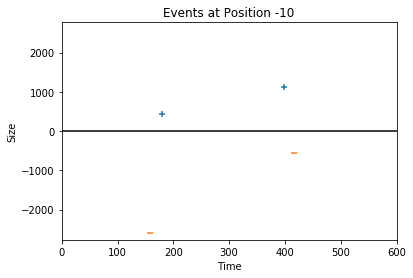

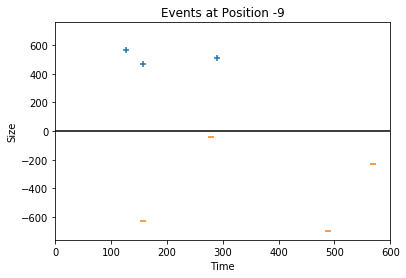

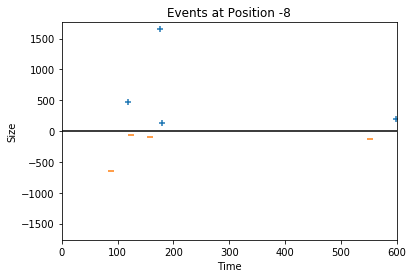

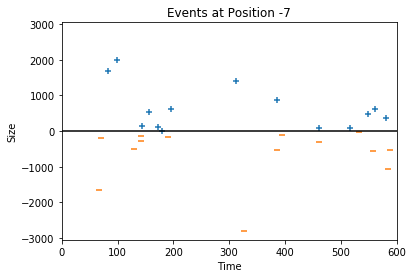

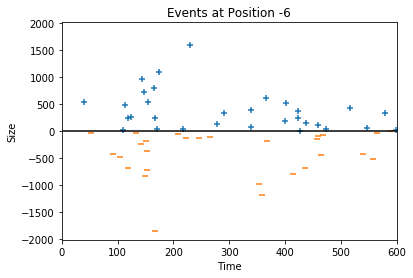

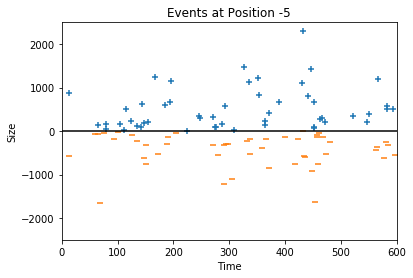

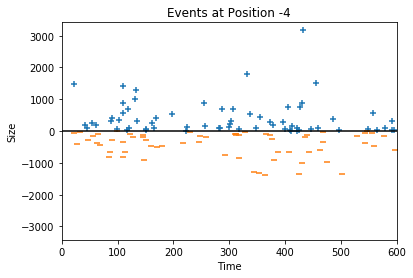

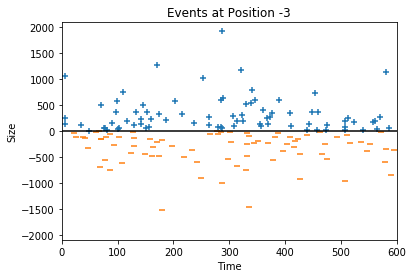

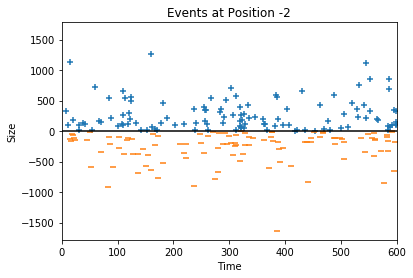

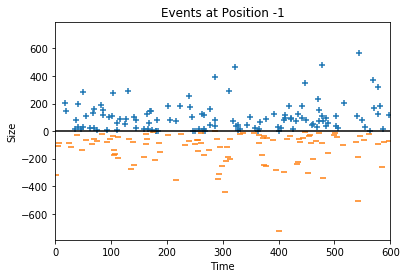

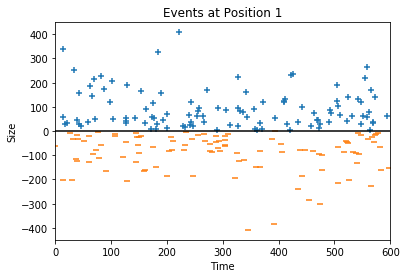

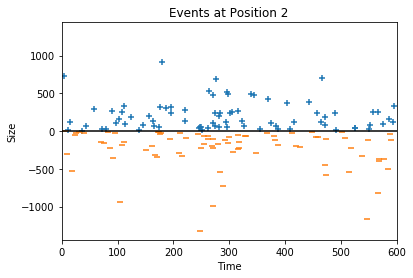

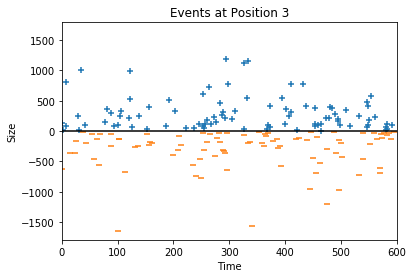

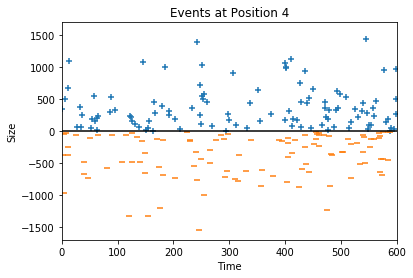

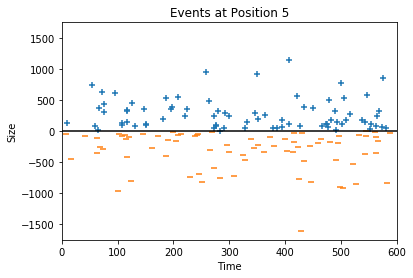

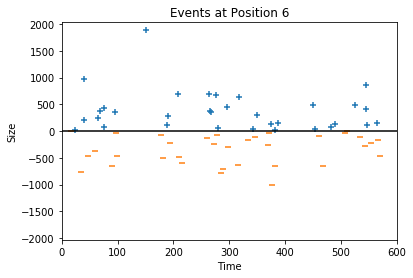

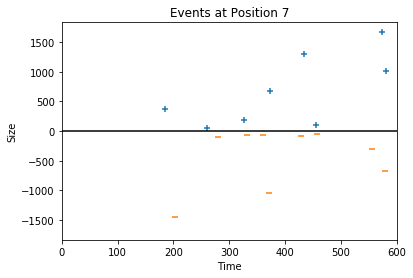

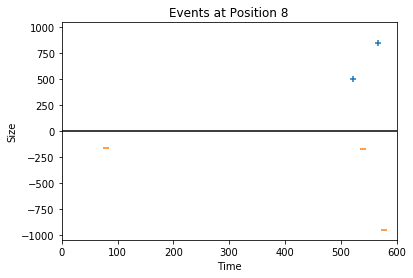

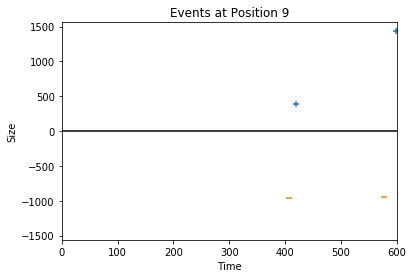

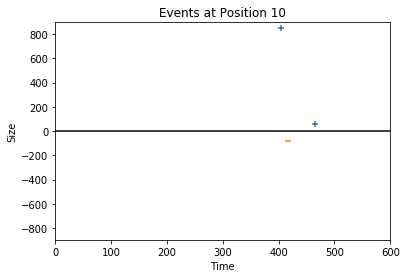

In [180]:
events = [arrivals_during_time_period(AESs_vector, average_rates_vector, sigma, i*60, 60) for i in range(10)]
events = [e for es in events for e in es]

for k in range(-K,K+1):
    if k != 0:
        events_at_k = [(e[0],e[1]) for e in events if e[2] == k]
        positive_events = [e for e in events_at_k if e[1] > 0]
        if len(positive_events) > 0:
            positive_times, positive_sizes = zip(*positive_events)
        else:
            positive_times, positive_sizes = [],[]
        negative_events = [e for e in events_at_k if e[1] < 0]
        if len(negative_events) > 0:
            negative_times, negative_sizes = zip(*negative_events)
        else:
            negative_times, negative_sizes = [],[]
        plt.scatter(positive_times, positive_sizes, marker="+")
        plt.scatter(negative_times, negative_sizes, marker="_")
        plt.axhline(0,color='k')
        plt.xlim([0, 600])
        plt.xlabel("Time")
        plt.ylabel("Size")
        lower, upper = plt.gca().get_ylim()
        lim = max(abs(lower),abs(upper))
        plt.ylim([-lim,lim])
        plt.title("Events at Position {}".format(k))
        plt.show()
        
plt.close()